# Mask R-CNN - Inspección de Ines (inferencia)

Aquí probamos y hacemos debug de nuestra Mask R-CNN.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob

# Directorio del mask_rcnn
ROOT_DIR = '/content/drive/My Drive/matterport_mask_rcnn'

In [0]:
# Es el ROOT del repositorio
ROOT_DIR = '/content/drive/My Drive/matterport_mask_rcnn'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Importamos las librerías
sys.path.append(ROOT_DIR)  # Encontramos versión locarl de las librerías

In [4]:
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.visualize import display_instances
from mrcnn.visualize import display_images
from mrcnn.model import log

#Direcotio absoluto del script
script_dir = '/content/drive/My Drive'


sys.path.append(os.path.abspath(script_dir))

import custom

%matplotlib inline 

# Aquí salvamos los logs y modelos entrenados
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

custom_WEIGHTS_PATH = '/content/drive/My Drive/matterport_mask_rcnn/logs/ine20190820T1623/mask_rcnn_ine_0010.h5'  # TODO: último registro entrenado

Using TensorFlow backend.


## Configuraciones

In [0]:
config = custom.CustomConfig()
custom_DIR = os.path.join(ROOT_DIR, "customImages")

In [6]:
# Hacemos un override en el modelo entrenado y algunos cambios
# cambios en la inferencia
class InferenceConfig(config.__class__):
    # Corremos detección una imagen a la vez
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook

In [0]:
# Donde cargaremos nuetra red.
# SI VAMOS A PREDECIR EN LA MISMA COMPUTADORA
# dejamos el mismo gpu, si no 
# se usará cpu para la inferencia
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspeeción del modelo en inferencia o entrenamiento
# valores: 'inference' o 'training'
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Punto central para controlar tamaño de las gráficas
    
    Ajustamos el tamaño para ver que tan grandes renderizamos la imagen
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Cargamos set de Validación

In [9]:
dataset = custom.CustomDataset()
dataset.load_custom('/content/drive/My Drive/dine', "val")

# Debemos de preparar antes del dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 16
Classes: ['BG', 'ine']


## Cargamos el modelo

In [10]:
# corremos en modo inferencia
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0821 15:44:10.641612 140262911735680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 15:44:10.648996 140262911735680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 15:44:10.654881 140262911735680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 15:44:10.687194 140262911735680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0821 15:44:10.692669 140262911

In [11]:
# cargamos el modelo entrenado por nosotros
# Cargamos pesos
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

Loading weights  /content/drive/My Drive/matterport_mask_rcnn/logs/ine20190820T1623/mask_rcnn_ine_0010.h5
Re-starting from epoch 10


In [12]:
from importlib import reload # deseperante estar cargando el cuaderno, solo se cambia así la visualización
reload(visualize)

<module 'mrcnn.visualize' from '/content/drive/My Drive/matterport_mask_rcnn/mrcnn/visualize.py'>

# Corremos detección en imágenes

image ID: ine.ine_0103.jpg (13) /content/drive/My Drive/dine/val/ine_0103.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  230.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  126.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  406.00000  max:  812.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


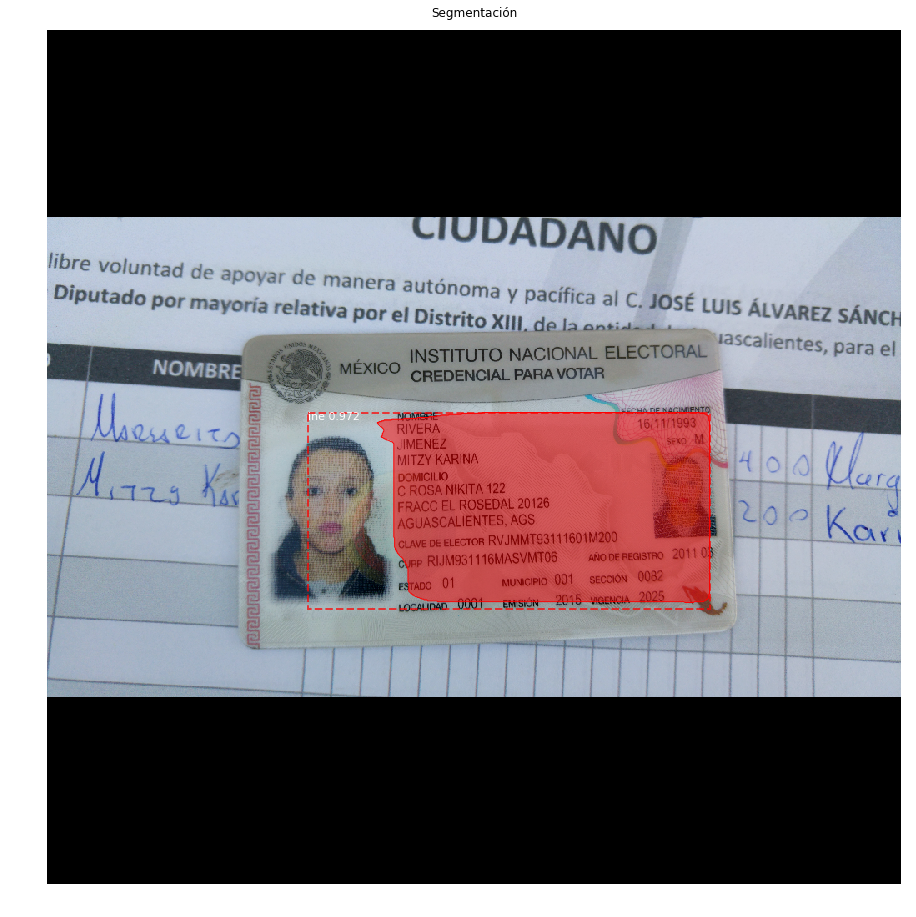

In [31]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Corremos detección en im
results = model.detect([image], verbose=1)

# Display
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Segmentación")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [15]:
mask = r['masks']
mask = mask.astype(int)
mask.shape
#Esta es la forma de la salida "máscara" no los canales

(1024, 1024, 1)

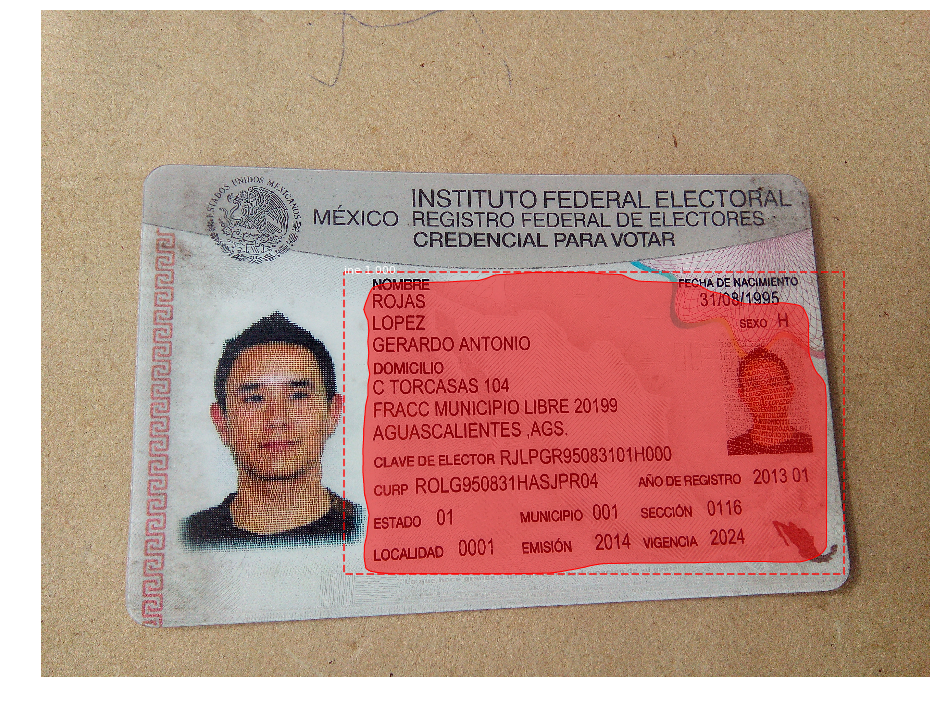

In [32]:
import skimage

path = '/content/drive/My Drive/dine/val/ine_0090.jpg'
image = skimage.io.imread(path)

# Corremos detección en una solo imagen
results = model.detect([image], verbose=0)

# Visualizamos
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])

In [0]:
def segment(image, r):
  idx = r['scores'].argmax()
  mask = r['masks'][:,:,idx]
  mask = np.stack((mask,)*3, axis=-1)
  mask = mask.astype('uint8')
  bg = 255 - mask * 255
  mask_img = image*mask
  result = mask_img+ bg
  return result

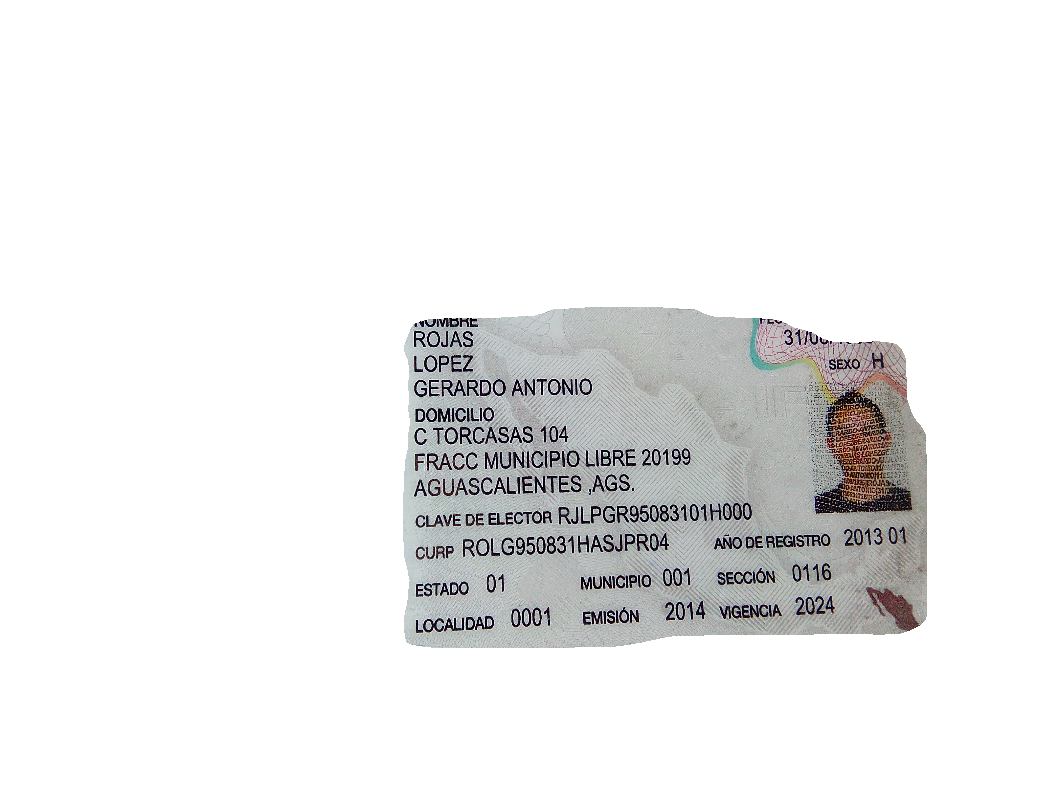

In [36]:
segmentacion = segment(image, r)
plt.subplots(1, figsize=(18, 18))
plt.axis('off')
plt.imshow(np.concatenate([segmentacion], axis = 1))